In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.linear_model import HuberRegressor

In [2]:
df = pd.read_csv('wand_export.csv')
substrings = ["MAX", "MIN"]
keep_cols = [col for col in df.columns 
             if not any(sub in col for sub in substrings)]
df = df.loc[:, keep_cols]
rename_dict = {col: col.split('-')[2] 
               for col in df.columns if col != 'Step'}
df = df.rename(columns=rename_dict)
df

,Step,71000,12000,24000,48000,6000,1000,2000,128,256,64,8
0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.098641
1,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.930866
2,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.822045
3,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.658034
4,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.542868
...,...,...,...,...,...,...,...,...,...,...,...,...
7258,71996,1.437879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7259,71997,1.494968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7260,71998,1.452195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7261,71999,1.527930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# a datapoint is a triple (pre-train steps, fine-tune steps, loss)
datapoints = []
for col in df.columns: 
    if col != "Step":
        columns_to_keep = ["Step", col]
        temp = df[columns_to_keep].dropna().rename(
            columns = {
                "Step": "finetune", col: "loss"
            })
        temp['finetune'] = temp['finetune'] - temp['finetune'].min() +1
        temp['pretrain'] = int(col)
        temp['finetune'] *= 128*2048
        temp['pretrain'] *= 1024*2048
        dict_repr = temp.to_dict(orient='records')
        datapoints = datapoints + dict_repr

print(datapoints[10])

{'finetune': 2883584, 'loss': 1.5681257247924805, 'pretrain': 148897792000}


[16777216, 134217728, 268435456, 536870912, 2097152000, 4194304000, 12582912000, 25165824000, 50331648000, 100663296000, 148897792000]


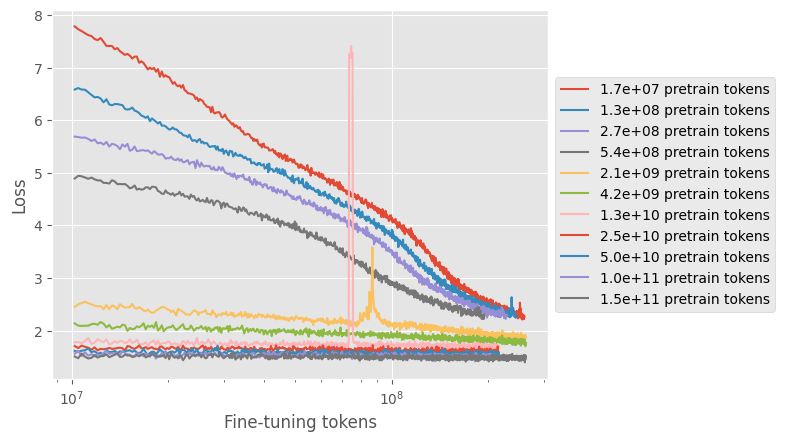

In [4]:
pretrain_values = set(x["pretrain"] for x in datapoints)
print(sorted(list(pretrain_values)))
plt.style.use('ggplot')

for pretrain in sorted(list(pretrain_values)): 
    finetunes = [x["finetune"] for x in datapoints if 
                x["pretrain"]==pretrain and x["finetune"]>10**7]
    losses = [x["loss"] for x in datapoints if 
                x["pretrain"]==pretrain and x["finetune"]>10**7]
    
    plt.plot(finetunes, losses, label="{:.1e} pretrain tokens".format(pretrain))

plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Fine-tuning tokens')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('ex1.png', bbox_inches='tight')
plt.show()



744
[262144, 6815744, 13369344, 19922944, 26476544, 39583744, 65798144, 92012544, 131334144, 157548544, 183762944]


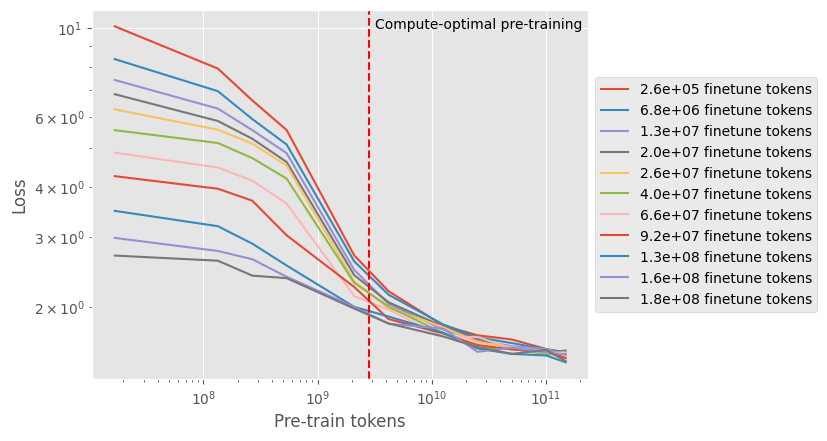

In [13]:
finetunes = [x["finetune"] for x in datapoints if x["pretrain"]==536870912 and x["finetune"]>10**1]
print(len(finetunes))
finetune_i = [0, 25, 50, 75, 100, 150, 250, 350, 500, 600, 700]
finetune_values = sorted(list([finetunes[i] for i in finetune_i]))
print(finetune_values)

plt.style.use('ggplot')

for finetune in sorted(list(finetune_values)): 
    temp_datapoints = sorted(datapoints, key=lambda x: x["pretrain"])
    pretrains = [x["pretrain"] for x in temp_datapoints if 
                x["finetune"]==finetune and x["pretrain"]]
    losses = [x["loss"] for x in temp_datapoints if 
                x["finetune"]==finetune and x["pretrain"]]
    
    plt.plot(pretrains, losses, label="{:.1e} finetune tokens".format(finetune))

plt.axvline(x=2.8*10**9, color='red', linestyle='--')
plt.text(3.2*10**9, 10, 'Compute-optimal pre-training', rotation=0)
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Pre-train tokens')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('ex2.png', bbox_inches='tight')
plt.show()


In [8]:
X = np.array([[math.log(x["pretrain"]), math.log(x["finetune"])] for x in datapoints])
y = np.array([math.log(x["loss"]) for x in datapoints])

huber = HuberRegressor()
out = huber.fit(X, y)

In [12]:
huber.coef_

array([-0.10843625, -0.09037364])